In [3]:
import networkx as nx
from types_definition import * 
from vector import Vector
from rotorconfig import RotorConfig
from rotorgraph import RotorGraph, display_path, all_config_from_recurrent, display_grid
from particleconfig import ParticleConfig
from matrices import Matrix
from arcsum import ArcSum
from arcmonic import Arcmonic
import numpy as np
from smithnormalform import matrix, snfproblem, z
from otherfunctions import *
import random


In [5]:
#Creation du graphe

import random

m=4
n=4

n= random.randint(3,20)
m= random.randint(3,20)

m=2

rotor_graph = RotorGraph.simple_path(n,m,m)


In [6]:
import random
sigma = ParticleConfig(rotor_graph)
rho = RotorConfig(rotor_graph)

#config de rotor au hazard
for i in range(1,n+1):
    eh= random.randint(0, len(rotor_graph.rotor_order[i])-1)
    rho[i]= rotor_graph.rotor_order[i][eh]

#config de particule au hazard
for i in range(1, n+1):
    sigma[i] = random.randint(0, 20) 

In [7]:
import numpy as np
#liste des diff:

diff = []

for i in range(n+1):
    diff.append([])
    for j in range(n+1):
        if j==i:
            diff[i].append(1)
        else:
            diff[i].append(0)
    diff[i].append(1)

diff_array = [np.array(ligne) for ligne in diff]

#print(diff_array)


#valeur harmonique d'un sommet
def h(sommet:int, n: int, diff_array):
    harmonic = np.array([0 for _ in range(n+2)])

    for i in range(sommet):
        harmonic += diff_array[i]
    return harmonic

#ordre du groupe

print(h(n+1,n,diff_array))
F= h(n+1,n,diff_array)[-1]


#valeur harmonique d'une config sigma
def h_sigma(sigma, n=n, diff_array=diff_array):
    h_sigma = 0
    for i in range(len(sigma)):
        h_sigma += sigma[i]*h(i,n,diff_array)
    return h_sigma


#affichage d'un calcul
print(h_sigma(sigma))
print(sigma)



#valeur arcmonique d'une config
def a_rho(rho, n=n, diff_array=diff_array):
    a_sigma = np.array([0 for _ in range(n+2)])
    for i in range(1,n+1):
        edge = rho[i]
        if edge[0]< edge[1]:
            a_sigma += edge[2]*diff_array[i]
        else:
            a_sigma += (m-edge[2])*diff_array[i-1] #

    return a_sigma

##affichage d'un calcul
print(a_rho(rho))
print(rho)



[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 17]
[144 139 122 102  82  75  61  53  36  36  26  26  14  12   4   3   0 935]
{0: 0, 1: 5, 2: 17, 3: 20, 4: 20, 5: 7, 6: 14, 7: 8, 8: 17, 9: 0, 10: 10, 11: 0, 12: 12, 13: 2, 14: 8, 15: 1, 16: 3, 17: 0}
[0 0 0 0 1 0 0 2 2 1 0 0 2 0 1 0 0 9]
{1: (1, 2, 0), 2: (2, 3, 0), 3: (3, 4, 0), 4: (4, 5, 1), 5: (5, 6, 0), 6: (6, 7, 0), 7: (7, 8, 1), 8: (8, 7, 1), 9: (9, 8, 0), 10: (10, 9, 1), 11: (11, 12, 0), 12: (12, 13, 0), 13: (13, 12, 0), 14: (14, 15, 1), 15: (15, 16, 0), 16: (16, 17, 0)}


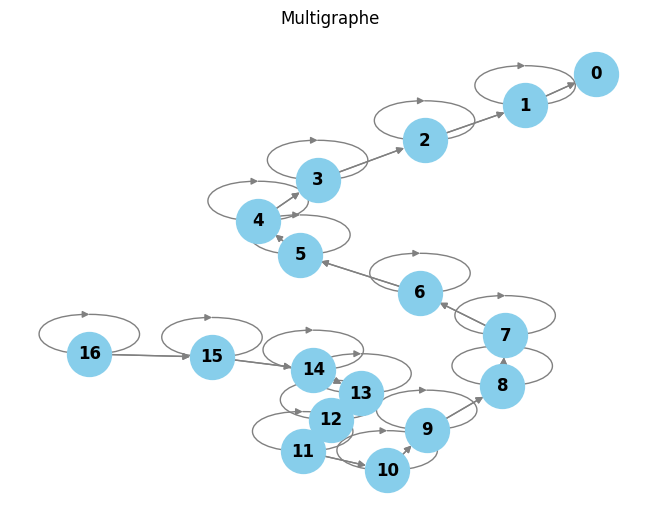

[(1, 0, 0), (1, 0, 1), (1, 1, 0), (2, 1, 0), (2, 1, 1), (2, 2, 0), (3, 2, 0), (3, 2, 1), (3, 3, 0), (4, 3, 0), (4, 3, 1), (4, 4, 0), (5, 4, 0), (5, 4, 1), (5, 5, 0), (6, 5, 0), (6, 5, 1), (6, 6, 0), (7, 6, 0), (7, 6, 1), (7, 7, 0), (8, 7, 0), (8, 7, 1), (8, 8, 0), (9, 8, 0), (9, 8, 1), (9, 9, 0), (10, 9, 0), (10, 9, 1), (10, 10, 0), (11, 10, 0), (11, 10, 1), (11, 11, 0), (12, 11, 0), (12, 11, 1), (12, 12, 0), (13, 12, 0), (13, 12, 1), (13, 13, 0), (14, 13, 0), (14, 13, 1), (14, 14, 0), (15, 14, 0), (15, 14, 1), (15, 15, 0), (16, 15, 0), (16, 15, 1), (16, 16, 0)]


In [8]:
Engel = RotorGraph()
for i in range(n+1): Engel.add_node(i)

for i in range(n,0,-1):
    for _ in range(m):
        Engel.add_edge(i,i-1)
    Engel.add_edge(i,i)

Engel_Laplacian = Engel.laplacian_matrix()
Engel_L= Engel_Laplacian.to_numpy()


import matplotlib.pyplot as plt

nx.draw(Engel, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold', edge_color='gray')

# Afficher le dessin
# plt.title("Multigraphe")
# plt.show()

# print(Engel.edges)




In [9]:
def stab_engel(vec,Engel=Engel):
    Engel_Laplacian = Engel.laplacian_matrix()
    Engel_L= Engel_Laplacian.to_numpy()

    sigma_engel = ParticleConfig(Engel)
    #initialisation
    for i in range(n+1):
        sigma_engel[i] = vec[i]
    
    for sommet in range(n,0,-1):
        while sigma_engel[sommet] >= m+1 or sigma_engel[sommet] <0:
            nb_tirage = (sigma_engel[sommet] - (sigma_engel[sommet])%(m+1))//(m+1)
            vec_tirage = nb_tirage * Engel_L[sommet]

            for j in range(n+1):
                sigma_engel[j]-=vec_tirage[j]

    return np.array(list(sigma_engel.values()))

#exemple de stabilisation.
vec = np.array([-22,-15,-9,-4,0])#  +8* np.array([1 for _ in range(n+1)])
#vec = np.array([5 for _ in range(n+1)])
#print(stab_engel(vec))



#recherche de la valeur stabilisante

def val_stab_engel(vec,Engel=Engel):
    val=0
    stab = stab_engel(vec,Engel=Engel)
    #print(val, stab)
    nb_m=0
    for el in stab:
            if el >= m:
                nb_m += el
                
    while stab[0]< 0 and nb_m+stab[0]<0:
        val +=1
        stab = stab_engel(vec + val*np.array([1 for _ in range(n+1)]) ,Engel=Engel)
        #print(val, stab)
        
        nb_m = 0
        for el in stab:
            if el >= m:
                nb_m += el
    return val, stab
#print(val_stab_engel(vec))


In [16]:
#gros exemple test de l'algo



import random
import math
import time



#config de rotor au hazard
rho = RotorConfig(rotor_graph)
for i in range(1,n+1):
    eh= random.randint(0, len(rotor_graph.rotor_order[i])-1)
    rho[i]= rotor_graph.rotor_order[i][eh]

#config de particule au hazard
sigma = ParticleConfig(rotor_graph)
for i in range(1, n+1):
    sigma[i] = random.randint(0, 100) 

###Routage normale avec une config de rotor et de particule aux hasards
#routage aux puits

t1 = time.time()
sigma_f, rho_f, info = rotor_graph.legal_routing(sigma, rho)
t2 = time.time()
#print("temps routage =", t2-t1)
print(sigma)
print(sigma_f)


t3= time.time()
a_rho_f = a_rho(rho_f)
a_rho_ff=np.array([a_rho_f[i] for i in range(len(a_rho_f)-1)])

#print(val_stab_engel(a_rho_ff))

####Test avec l'algo


vect = a_rho(rho)-h_sigma(sigma)



vec = np.array([vect[i] for i in range(len(vect)-1)])

if vect[-1] < 0:
    
    val = math.ceil(-vect[-1]/F)
    vec += val*np.array([1 for _ in range(n+1)])

#accéléer le truc en rendant la dernière composante positive


b,c = val_stab_engel(vec)
t4= time.time()

b= b+val
#print(val,b,c)
print(b)
#print("temps algo =", t4-t3)


temps routage = 2.1632330417633057
{0: 0, 1: 94, 2: 46, 3: 15, 4: 83, 5: 73, 6: 90, 7: 14, 8: 13, 9: 83, 10: 69, 11: 53, 12: 49, 13: 26, 14: 98, 15: 4, 16: 87, 17: 0}
{0: 459, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 438}
438
temps algo = 0.002367734909057617
